In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [3]:
import xarray as xr
from scipy.interpolate import RectBivariateSpline, griddata

In [4]:
import utm

In [5]:
from stl import mesh  # install with `pip install numpy-stl`

/Users/equon/anaconda3/envs/forge/lib/python3.7/importlib/_bootstrap.py:219: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return f(*args, **kwds)


In [6]:
from mmctools.coupling.terrain import SRTM

# Terrain-Resolved Domain Setup
This notebook will generate a surface geometry file to be used by the microscale solver (e.g., SOWFA) to conform the solver domain to the terrain (e.g., with `moveDynamicMesh`).

In [7]:
# PS12 met mast
refloc = (45.638004, -120.642973, 495)

In [8]:
# WFIP2 region to clip from the digital elevation model (DEM)
srtm_bounds = west, south, east, north = (-121.0, 45.40, -120.3, 45.88)
srtm_output = '/Users/equon/a2e-mmc/SOWFA-setups/wfip2_terrain/constant/Physics_site.tif'  # need absolute path for GDAL

In [9]:
# WRF reference solution
wrfout = '/Users/equon/MMC/WFIP2Region/20161121_YSU/wrfout_d01_2016-11-22_00:00:00'

In [10]:
# microscale parameters (from SOWFA setUp)
xmin,xmax = -14500, 16000
ymin,ymax = -4500, 8000
ds = 10. # output resolution

In [11]:
# blending parameters between low- (mesoscale) and high- (SRTM) resolution DEMs
fringe_w = 3000.
fringe_s = 1500.
fringe_n = 1500.
fringe_e = 0.

In [12]:
# output STL file
stlout = 'constant/triSurface/wfip2_physics_site.stl'

## 1. Create output surface

In [13]:
x1 = np.arange(xmin, xmax+ds, ds)
y1 = np.arange(ymin, ymax+ds, ds)
xsurf,ysurf = np.meshgrid(x1, y1, indexing='ij')

## 2. Get the high-resolution terrain

In [14]:
srtm = SRTM(srtm_bounds, fpath=srtm_output, product='SRTM1')

In [15]:
%time srtm.download()
# CPU times: user 3.53 ms, sys: 12.7 ms, total: 16.2 ms
# Wall time: 8.74 s

CPU times: user 3.44 ms, sys: 12.6 ms, total: 16 ms
Wall time: 8.98 s


In [16]:
%%time
x,y,z = srtm.to_terrain()
z.shape

Output grid at ds= 30.0
EPSG code: 32610
CPU times: user 617 ms, sys: 79 ms, total: 696 ms
Wall time: 696 ms


(2141, 2086)

In [17]:
# get reference location to use as origin
xref,yref,_,_ = utm.from_latlon(*refloc[:2], force_zone_number=srtm.zone_number)

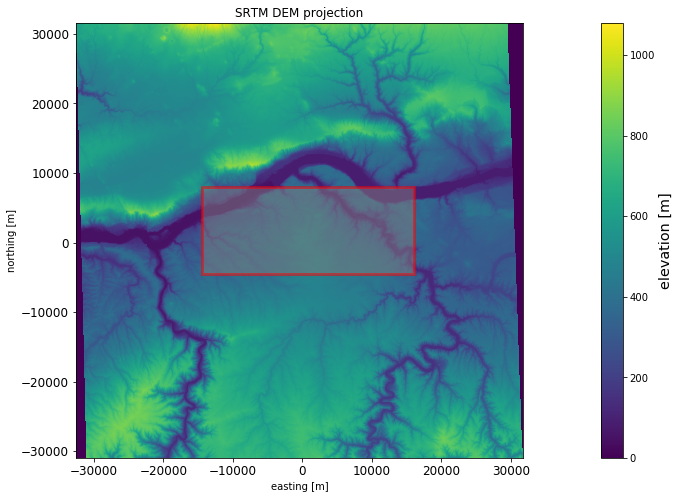

In [18]:
fig,ax = plt.subplots(figsize=(12,8))
cm = ax.pcolormesh(x-xref, y-yref, z, cmap='viridis')#,vmin=vmin,vmax=vmax)
cb = fig.colorbar(cm,ax=ax)
cb.set_label('elevation [m]',fontsize='x-large')
ax.tick_params(labelsize='large')
ax.set_xlabel('easting [m]')
ax.set_ylabel('northing [m]')
ax.set_title('SRTM DEM projection')
ax.axis('scaled')

# bounding box for microscale region
les = Rectangle((xmin,ymin), xmax-xmin, ymax-ymin, edgecolor='r', lw=3, facecolor='0.5', alpha=0.5)
ax.add_patch(les)

### downscale to output grid

In [19]:
interpfun = RectBivariateSpline(x[:,0]-xref, y[0,:]-yref, z)

In [20]:
zsrtm = interpfun(x1,y1,grid=True)

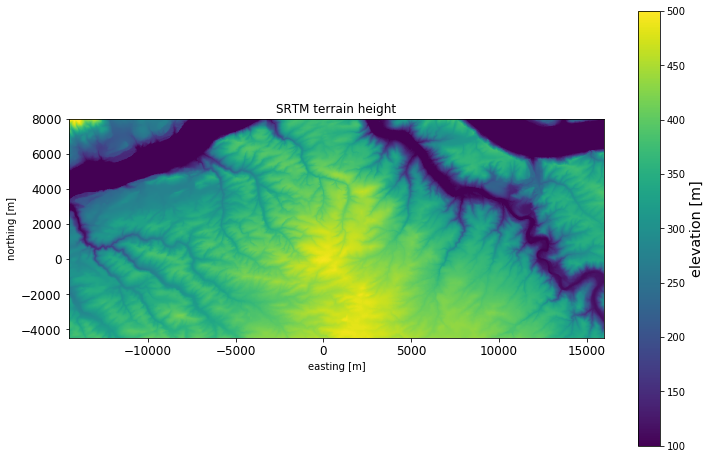

In [21]:
vmin,vmax = 100,500

fig,ax = plt.subplots(figsize=(12,8))
cm = ax.pcolormesh(xsurf, ysurf, zsrtm, cmap='viridis',vmin=vmin,vmax=vmax)
cb = fig.colorbar(cm,ax=ax)
cb.set_label('elevation [m]',fontsize='x-large')
ax.tick_params(labelsize='large')
ax.set_xlabel('easting [m]')
ax.set_ylabel('northing [m]')
ax.set_title('SRTM terrain height')
ax.axis('scaled')
fig.savefig('elevation_srtm.png',dpi=150,bbox_inches='tight')

## 3. Get the lower-resolution terrain from the mesoscale

In [22]:
wrf = xr.open_dataset(wrfout)
wrf['HGT']

<xarray.DataArray 'HGT' (Time: 1, south_north: 350, west_east: 380)>
[133000 values with dtype=float32]
Coordinates:
    XLAT     (Time, south_north, west_east) float32 ...
    XLONG    (Time, south_north, west_east) float32 ...
    XTIME    (Time) datetime64[ns] ...
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  Terrain Height
    units:        m
    stagger:      

In [23]:
# wrf fields
hgt = wrf['HGT'][0,:,:]
xlat = wrf.coords['XLAT'][0,:,:]
xlon = wrf.coords['XLONG'][0,:,:]

In [24]:
# %%time
# # convert output cartesian grid to lat/lon - there's probably a more efficient way to do this
# Npts = np.prod(xsurf.shape)
# output_lat = np.empty(Npts)
# output_lon = np.empty(Npts)
# for ipt,(xi,yi) in enumerate(zip(xsurf.ravel()+xref, ysurf.ravel()+yref)):
#     output_lat[ipt],output_lon[ipt] = utm.to_latlon(xi, yi,
#                                                     zone_number=srtm.zone_number,
#                                                     zone_letter=srtm.zone_letter)
# # CPU times: user 2min 47s, sys: 173 ms, total: 2min 48s
# # Wall time: 2min 48s

%time output_lat, output_lon = srtm.to_latlon(xsurf.ravel()+xref, ysurf.ravel()+yref)
# CPU times: user 3.38 s, sys: 157 ms, total: 3.54 s
# Wall time: 3.54 s

CPU times: user 3.44 s, sys: 167 ms, total: 3.61 s
Wall time: 3.61 s


In [25]:
%%time
# interpolate to wrf surface elevation based on lat/lon
xi = np.stack((output_lat.ravel(),output_lon.ravel()),axis=-1)
points = np.stack((xlat.values.ravel(),xlon.values.ravel()),axis=-1)
values = hgt.values.ravel()
zi = griddata(points,values,xi)
zwrf = zi.reshape(xsurf.shape)
# CPU times: user 3.14 s, sys: 931 ms, total: 4.07 s
# Wall time: 2.57 s

CPU times: user 3.02 s, sys: 680 ms, total: 3.71 s
Wall time: 2.32 s


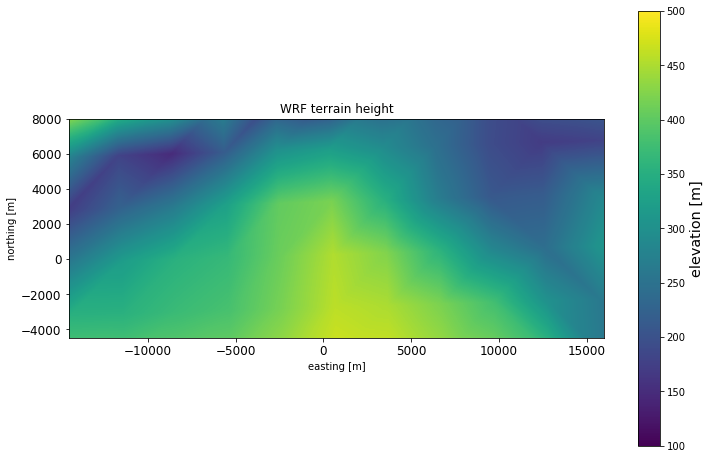

In [26]:
fig,ax = plt.subplots(figsize=(12,8))
cm = ax.pcolormesh(xsurf, ysurf, zwrf, cmap='viridis',vmin=vmin,vmax=vmax)
cb = fig.colorbar(cm,ax=ax)
cb.set_label('elevation [m]',fontsize='x-large')
ax.tick_params(labelsize='large')
ax.set_xlabel('easting [m]')
ax.set_ylabel('northing [m]')
ax.set_title('WRF terrain height')
ax.axis('scaled')
fig.savefig('elevation_wrf.png',dpi=150,bbox_inches='tight')

## 4. blend surface definitions

In [27]:
# check distance from west boundary
blend_w = np.ones(xsurf.shape)
if fringe_w > 0:
    blend_w = np.minimum((xsurf-xmin)/fringe_w, 1)

In [28]:
# check distance from east boundary
blend_e = np.ones(xsurf.shape)
if fringe_e > 0:
    blend_e = np.minimum((xmax-xsurf)/fringe_e, 1)

In [29]:
# check distance from south boundary
blend_s = np.ones(xsurf.shape)
if fringe_s > 0:
    blend_s = np.minimum((ysurf-ymin)/fringe_s, 1)

In [30]:
# check distance from north boundary
blend_n = np.ones(xsurf.shape)
if fringe_n > 0:
    blend_n = np.minimum((ymax-ysurf)/fringe_n, 1)

In [31]:
# combine blending functions
blend = np.minimum(np.minimum(np.minimum(blend_n, blend_e), blend_s), blend_w)

(-14500.0, 16000.0, -4500.0, 8000.0)

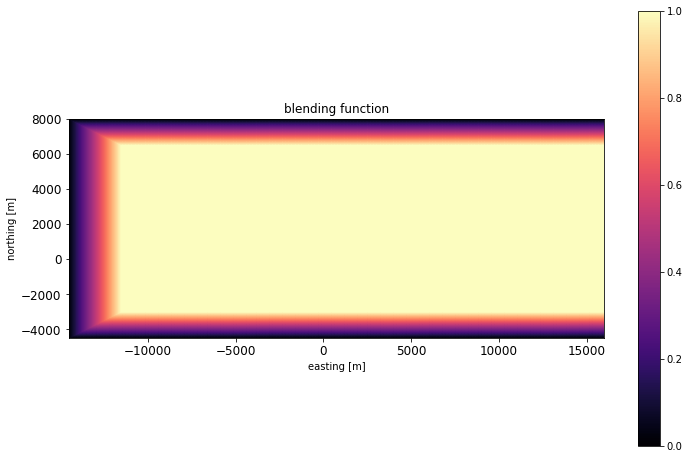

In [32]:
fig,ax = plt.subplots(figsize=(12,8))
cm = ax.pcolormesh(xsurf, ysurf, blend, cmap='magma')
cb = fig.colorbar(cm,ax=ax)
ax.tick_params(labelsize='large')
ax.set_xlabel('easting [m]')
ax.set_ylabel('northing [m]')
ax.set_title('blending function')
ax.axis('scaled')

In [33]:
# now, blend the high/low resolution elevations
zblend = blend*zsrtm + (1-blend)*zwrf

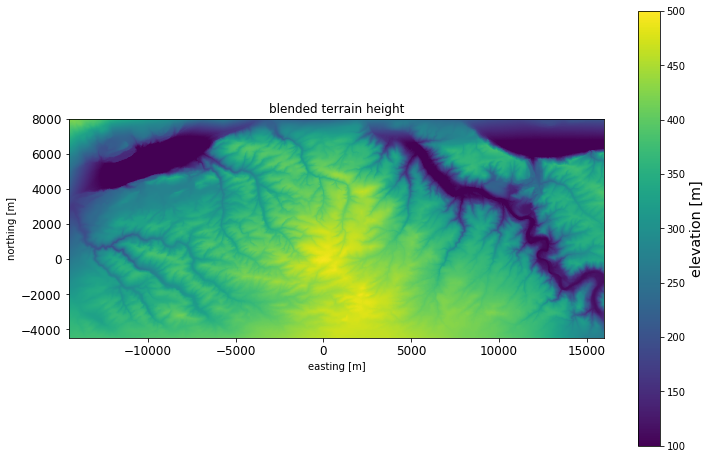

In [34]:
fig,ax = plt.subplots(figsize=(12,8))
cm = ax.pcolormesh(xsurf, ysurf, zblend, cmap='viridis',vmin=vmin,vmax=vmax)
cb = fig.colorbar(cm,ax=ax)
cb.set_label('elevation [m]',fontsize='x-large')
ax.tick_params(labelsize='large')
ax.set_xlabel('easting [m]')
ax.set_ylabel('northing [m]')
ax.set_title('blended terrain height')
ax.axis('scaled')
fig.savefig('elevation_blended.png',dpi=150,bbox_inches='tight')

## 5. Write out terrain surface STL

In [35]:
Npts = np.prod(xsurf.shape)
stlpoints = np.stack((xsurf.ravel(),ysurf.ravel(),zblend.ravel()),axis=-1)
stlindices = np.reshape(np.arange(Npts), xsurf.shape)

In [36]:
%%time
Nx,Ny = xsurf.shape
Nfaces = (Nx-1)*(Ny-1)*2

surf = mesh.Mesh(np.zeros(Nfaces, dtype=mesh.Mesh.dtype))

#
# manually define triangular faces for this simple quad mesh
#
# for iface, f in enumerate(faces):
#     for dim in range(3):
#         surf.vectors[iface][dim] = vertices[f[dim],:]
iface = 0 
for i in range(Nx-1):
    for j in range(Ny-1):
        surf.vectors[iface,0,:] = stlpoints[stlindices[i,j],:]
        surf.vectors[iface,1,:] = stlpoints[stlindices[i+1,j],:]
        surf.vectors[iface,2,:] = stlpoints[stlindices[i+1,j+1],:]
        surf.vectors[iface+1,0,:] = stlpoints[stlindices[i+1,j+1],:]
        surf.vectors[iface+1,1,:] = stlpoints[stlindices[i,j+1],:]
        surf.vectors[iface+1,2,:] = stlpoints[stlindices[i,j],:]
        iface += 2
assert (iface == Nfaces)
# CPU times: user 27.5 s, sys: 182 ms, total: 27.7 s
# Wall time: 27.7 s

CPU times: user 26.3 s, sys: 184 ms, total: 26.5 s
Wall time: 26.5 s


In [37]:
dpath = os.path.dirname(stlout)
if (not dpath == '') and (not os.path.isdir(dpath)):
    os.makedirs(dpath)
    print('Created',dpath)
    
surf.save(stlout)
print('Saved',stlout)

Created constant/triSurface
Saved constant/triSurface/wfip2_physics_site.stl
